In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import glob 
import math 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# The Dataset: 
@article{VARGAS2019106223,
title = "A realistic and public dataset with rare undesirable real events in oil wells",
journal = "Journal of Petroleum Science and Engineering",
volume = "181",
pages = "106223",
year = "2019",
issn = "0920-4105",
doi = "https://doi.org/10.1016/j.petrol.2019.106223",
url = "http://www.sciencedirect.com/science/article/pii/S0920410519306357",
author = "Ricardo Emanuel Vaz Vargas and Celso José Munaro and Patrick Marques Ciarelli and André Gonçalves Medeiros and Bruno Guberfain do Amaral and Daniel Centurion Barrionuevo and Jean Carlos Dias de Araújo and Jorge Lins Ribeiro and Lucas Pierezan Magalhães",
keywords = "Fault detection and diagnosis, Oil well monitoring, Abnormal event management, Multivariate time series classification",
abstract = "Detection of undesirable events in oil and gas wells can help prevent production losses, environmental accidents, and human casualties and reduce maintenance costs. The scarcity of measurements in such processes is a drawback due to the low reliability of instrumentation in such hostile environments. Another issue is the absence of adequately structured data related to events that should be detected. To contribute to providing a priori knowledge about undesirable events for diagnostic algorithms in offshore naturally flowing wells, this work presents an original and valuable dataset with instances of eight types of undesirable events characterized by eight process variables. Many hours of expert work were required to validate historical instances and to produce simulated and hand-drawn instances that can be useful to distinguish normal and abnormal actual events under different operating conditions. The choices made during this dataset's preparation are described and justified, and specific benchmarks that practitioners and researchers can use together with the published dataset are defined. This work has resulted in two relevant contributions. A challenging public dataset that can be used as a benchmark for the development of (i) machine learning techniques related to inherent difficulties of actual data, and (ii) methods for specific tasks associated with detecting and diagnosing undesirable events in offshore naturally flowing oil and gas wells. The other contribution is the proposal of the defined benchmarks."
}
Vargas, Ricardo; Munaro, Celso; Ciarelli, Patrick; Medeiros, André; Amaral, Bruno; Barrionuevo, Daniel; Araújo, Jean; Ribeiro, Jorge; Magalhães, Lucas (2019), “Data for: A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells”, Mendeley Data, v1. http://dx.doi.org/10.17632/r7774rwc7v.1 

**Class labels:** 
* 0 - normal 
* 1 - abrupt increase of BSW (ratio between water and sediment flow rate and liquid flow rate) 
* 2 - spurious closure of DHSV (any malfunction will result in DSV valve automatically closing)
* 3 - severe slugging (critical instability)
* 4 - flow instability
* 5 - rapid productivity loss
* 6 - quick restriction in pck 
* 7 - scaling in pck 
* 8 - hydrate in production line

In [8]:
#loading sample files from each class 
sample_frag_0 = pd.read_csv("../input/3w-dataset/3W/0/WELL-00001_20170201020207.csv", index_col = "timestamp", parse_dates = True)
sample_frag_1 = pd.read_csv("../input/3w-dataset/3W/1/SIMULATED_00014.csv", index_col = "timestamp", parse_dates = True)
sample_frag_2 = pd.read_csv("../input/3w-dataset/3W/2/WELL-00011_20140921200031.csv", index_col = "timestamp", parse_dates = True)
sample_frag_3 = pd.read_csv("../input/3w-dataset/3W/3/SIMULATED_00027.csv", index_col = "timestamp", parse_dates = True)
sample_frag_4 = pd.read_csv("../input/3w-dataset/3W/4/WELL-00001_20170317000000.csv", index_col = "timestamp", parse_dates = True)
sample_frag_5 = pd.read_csv("../input/3w-dataset/3W/5/SIMULATED_00026.csv", index_col = "timestamp", parse_dates = True)
sample_frag_6 = pd.read_csv("../input/3w-dataset/3W/6/SIMULATED_00015.csv", index_col = "timestamp", parse_dates = True)
sample_frag_7 = pd.read_csv("../input/3w-dataset/3W/7/WELL-00018_20180611040207.csv", index_col = "timestamp", parse_dates = True)
sample_frag_8 = pd.read_csv("../input/3w-dataset/3W/8/SIMULATED_00007.csv", index_col = "timestamp", parse_dates = True)

In [9]:
sample_frag_1.tail()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,
2018-10-07 07:56:26,20494190.0,11752570.0,96.06386,1113383.0,79.18683,NaN,NaN,NaN,1
2018-10-07 07:56:27,20494190.0,11752570.0,96.06386,1113383.0,79.18683,NaN,NaN,NaN,1
2018-10-07 07:56:28,20494190.0,11752570.0,96.06386,1113383.0,79.18683,NaN,NaN,NaN,1
2018-10-07 07:56:29,20494190.0,11752570.0,96.06386,1113383.0,79.18683,NaN,NaN,NaN,1
2018-10-07 07:56:30,20494190.0,11752570.0,96.06386,1113383.0,79.18683,NaN,NaN,NaN,1


In [5]:
def show_lineplot(file):
    plotted = file.drop(['class'], axis = 1)
    sns.lineplot(data = plotted)

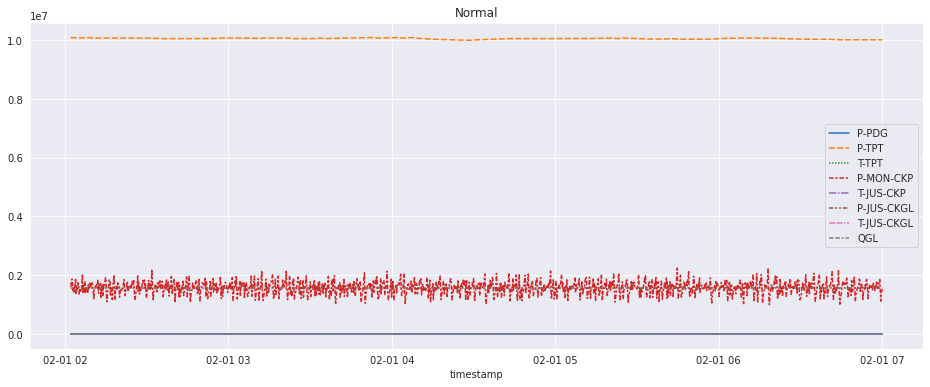

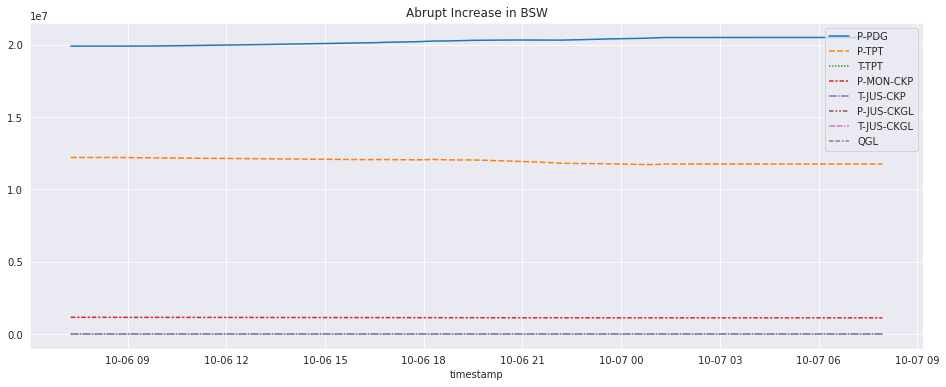

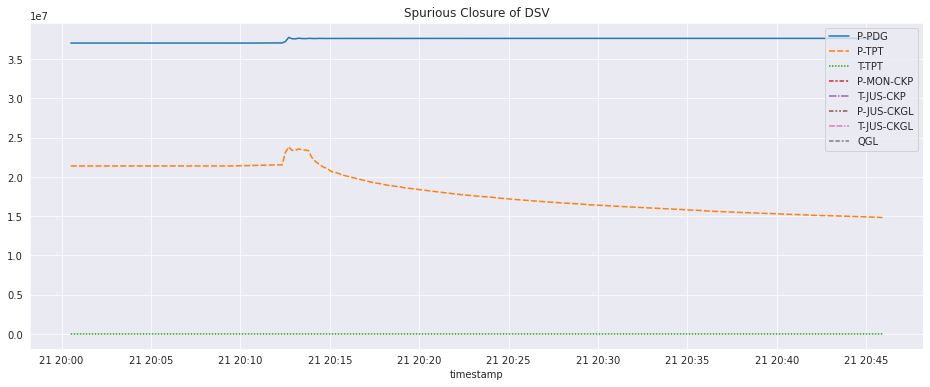

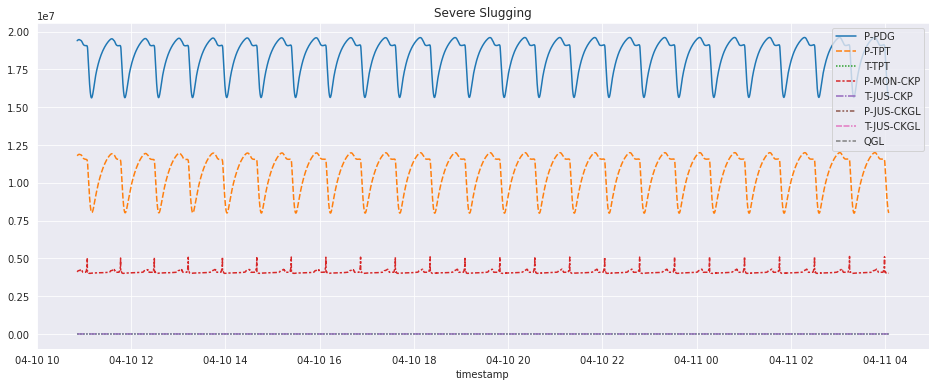

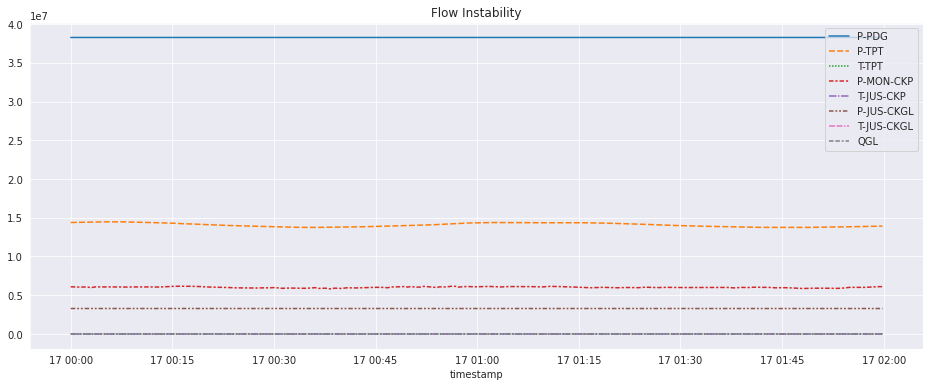

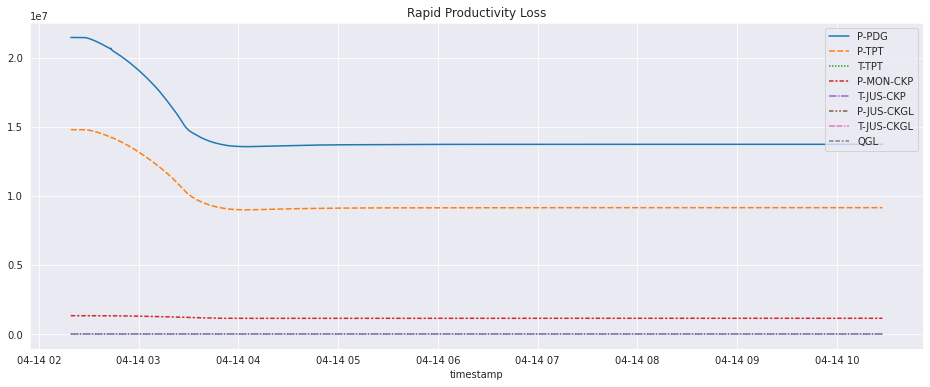

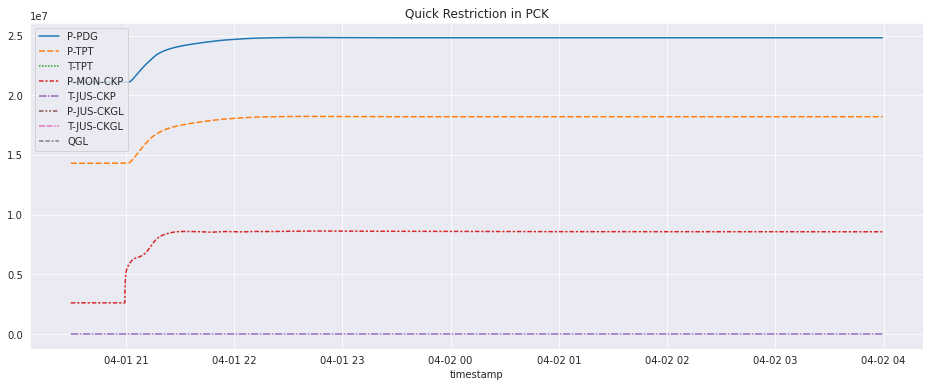

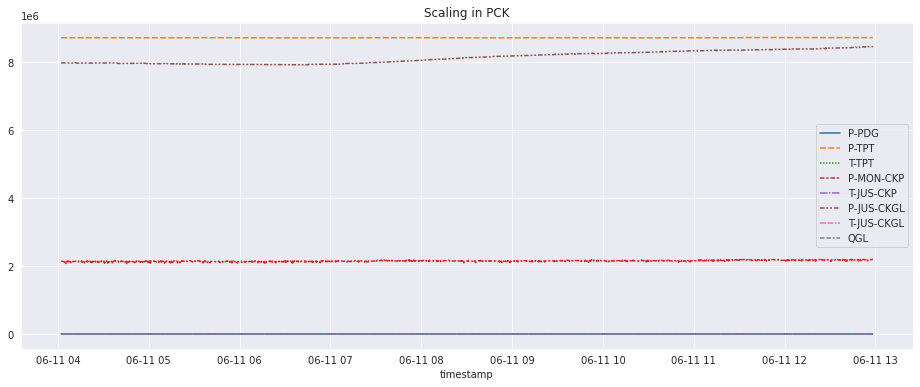

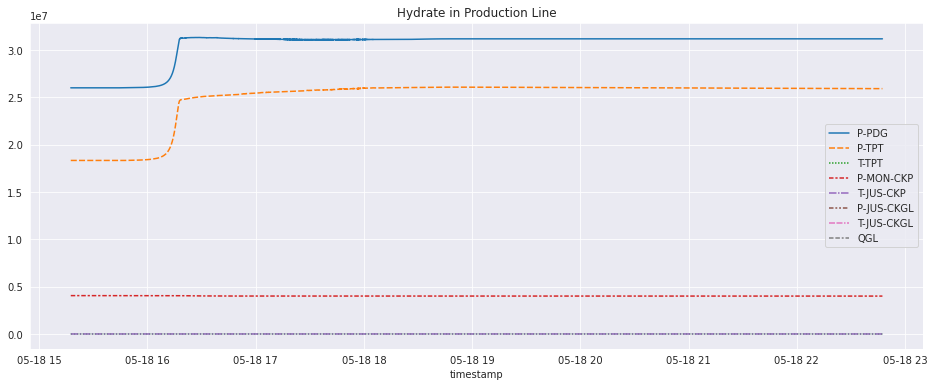

In [6]:
sns.set_style('darkgrid')

plt.figure(figsize = (16,6))
plt.title("Normal")
show_lineplot(sample_frag_0)
#
plt.figure(figsize = (16,6))
plt.title("Abrupt Increase in BSW")
show_lineplot(sample_frag_1)
#
plt.figure(figsize = (16,6))
plt.title("Spurious Closure of DSV")
show_lineplot(sample_frag_2)
#
plt.figure(figsize = (16,6))
plt.title("Severe Slugging")
show_lineplot(sample_frag_3)
#
plt.figure(figsize = (16,6))
plt.title("Flow Instability")
show_lineplot(sample_frag_4)
#
plt.figure(figsize = (16,6))
plt.title("Rapid Productivity Loss")
show_lineplot(sample_frag_5)
#
plt.figure(figsize = (16,6))
plt.title("Quick Restriction in PCK")
show_lineplot(sample_frag_6)
#
plt.figure(figsize = (16,6))
plt.title("Scaling in PCK")
show_lineplot(sample_frag_7)
#
plt.figure(figsize = (16,6))
plt.title("Hydrate in Production Line")
show_lineplot(sample_frag_8)

In [10]:
sample_frag_0.describe().round()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
count,17874.0,17874.0,17874.0,17874.0,17874.0,17874.0,0.0,17874.0,17874.0
mean,0.0,10055353.0,119.0,1579691.0,84.0,1565949.0,NaN,0.0,0.0
std,0.0,21292.0,0.0,178386.0,0.0,1040.0,NaN,0.0,0.0
min,0.0,9994737.0,119.0,996067.0,83.0,1564147.0,NaN,0.0,0.0
25%,0.0,10042100.0,119.0,1473036.0,84.0,1565048.0,NaN,0.0,0.0
50%,0.0,10054590.0,119.0,1589945.0,84.0,1565949.0,NaN,0.0,0.0
75%,0.0,10074540.0,119.0,1690882.0,85.0,1566849.0,NaN,0.0,0.0
max,0.0,10094480.0,119.0,2240969.0,85.0,1567750.0,NaN,0.0,0.0


The lineplots are useful in seeing what trends we're looking for, but they also show that there is a lot of missing data we need to take care of.

In [ ]:

class_0_frags = glob.glob("../input/3w-dataset/3W/0/*")
class_1_frags = glob.glob("../input/3w-dataset/3W/1/*")
class_2_frags = glob.glob("../input/3w-dataset/3W/2/*")
class_3_frags = glob.glob("../input/3w-dataset/3W/3/*")
class_4_frags = glob.glob("../input/3w-dataset/3W/4/*")
class_5_frags = glob.glob("../input/3w-dataset/3W/5/*")
class_6_frags = glob.glob("../input/3w-dataset/3W/6/*")
class_7_frags = glob.glob("../input/3w-dataset/3W/7/*")
class_8_frags = glob.glob("../input/3w-dataset/3W/8/*")

dataset_sizes = [len(class_0_frags),
                len(class_1_frags),
                len(class_2_frags),
                len(class_3_frags),
                len(class_4_frags),
                len(class_5_frags),
                len(class_6_frags),
                len(class_7_frags),
                len(class_8_frags)]

In [ ]:
dataset_sizes

In [ ]:
dataset=[]
labels=[]

pr=500# timesteps prior to event starting point
af=500# timesteps after event starting point
m=700 #size of sample in timesteps
slide=100
timewindow=pr+af
rawdata = os.scandir('../input/3w-dataset/3W/')
c=0

for entry in rawdata:
    group=os.scandir('../input/3w-dataset/3W/'+entry.name)
    foldername='../input/3w-dataset/3W/'+entry.name
    for entry in group:
        dataset.append(foldername+'/'+entry.name)
        labels.append(c)
    c+=1


def img(a):
    A=np.zeros((m+1))
    for i in range(4): # cycle for extracting  4 samples from timewindow
        startP=i*100
        if i==0:
            A=a[startP:startP+m]
            maxV=max(A)
            minV=min(A)
            d=maxV-minV
            for j in range(m):
                A[j]=(A[j]-minV)/d # erasing absolute value feature by rescaling
            A.append(d/maxV) # adding scale coefficient sv
        else:
            B=a[startP:startP+m]
            maxV=max(B)
            minV=min(B)
            d=maxV-minV
            for j in range(m):
                B[j]=(B[j]-minV)/d# erasing absolute value feature by rescaling
            B.append(d/maxV) # adding scale coefficient sv
            A=np.vstack((A,B))
    return(A)


i=0
for row in dataset:
    n=dataset[i]
    with  open(n, newline='') as f:
        reader = csv.reader(f)
        p0,p1,t1,p2,t2,pd=[],[],[],[],[],[]
        p00,p01,t01,p02,t02,pd=[],[],[],[],[],[]
        ii=0
        state=1 # flag that subsequently changes its value at event’s starting point to the corresponding ii value
        for row in reader:
            ii+=1
            if ii>1 and state>0:                
                p00.append(1) if float(row[1]+'0')<=0 else p00.append(0)
                p01.append(1) if float(row[2]+'0')<=0 else p01.append(0)
                t01.append(1) if float(row[3]+'0')<=0 else t01.append(0) 
                p02.append(1) if float(row[4]+'0')<=0 else p02.append(0)
                t02.append(1) if float(row[5]+'0')<=0 else t02.append(0)              
                p0.append(float(row[1])*(1+(np.random.sample()*1-1)/100)) if row[1]!='' else p0.append('NaN') # erasing signal #noise feature by adding random noise
                p1.append(float(row[2])*(1+(np.random.sample()*1-1)/100)) if row[2]!='' else p1.append('NaN') # erasing signal #noise feature by adding random noise
                t1.append(float(row[3])*(1+(np.random.sample()*1-1)/100)) if row[3]!='' else t1.append('NaN') # erasing signal #noise feature by adding random noise
                p2.append(float(row[4])*(1+(np.random.sample()*1-1)/100)) if row[4]!='' else p2.append('NaN') # erasing signal #noise feature by adding random noise
                t2.append(float(row[5])*(1+(np.random.sample()*1-1)/100)) if row[5]!='' else t2.append('NaN')     # erasing signal #noise feature by adding random noise          
                if float('0'+row[9])>100 and state==1: state=ii #locating event’s starting point in instance ( inner labeling of #timesteps is in the last column)
                if ii-state>=(af-1) and state>1: state=0
        if pr+af<=len(p0): #cropping raw data and centering the  starting  point. If an instance doesn’t include the starting point #(classes 4 and 5) then the last 1000 timesteps of the instance are extracted 
            del p0[:-(pr+af)]
            del p1[:-(pr+af)]
            del t1[:-(pr+af)]
            del p2[:-(pr+af)]
            del t2[:-(pr+af)]
            del p00[:-(pr+af)]
            del p01[:-(pr+af)]
            del t01[:-(pr+af)]
            del p02[:-(pr+af)]
            del t02[:-(pr+af)]
            p0s=sum(p00)
            p1s=sum(p01)
            t1s=sum(t01)
            p2s=sum(p02)
            t2s=sum(t02)
            if p1s==0 and p2s==0 and t2s==0: # erasing missing data pattern feature by deleting p0, t1 from samples and deleting samples with missing data p1,p2, and t2 
                Str=np.hstack([[[labels[i]],[labels[i]],[labels[i]],[labels[i]]],img(p1),img(p2),img(t2),[[1],[2],[3],[4]]])
                if i==0:
                    rez=Str  
                else:
                    rez=np.vstack((rez,Str))
    i+=1

np.savetxt("2.csv",rez, delimiter=",")

> # defining the model

In [ ]:
def AE(X): 
    inputs = Input(X.shape[1], X.shape[2])
    L1 = LSTM(16, activation = 'relu', return_sequences = True, 
             kernel_regularizer = )